# Simulating 2D Toy Ising Models

In this notebook I've created a toy model for simulating 2D Ising models with varying parameters. Simulation can either be done using exact computation of Monte Carlo heat bath sampling. The interactions between the spins are encoded in a weight matrix. The spins can be set to have only nearest-neighbor interactions or to be fully connected. In the simulation, the intensive values of the 2D spin lattice are calculated and plotted. The statistics <Ci> and <CiCj> are also calculated and stored.

In [1]:
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# WEIGHT FUNCTIONS
#-----------------------------------------------------------------------------------------------------------
def generate_weights_random(L, w, h, seed, sigma):
    '''Generates a symmetric random weights array drawn from a normal distribution for a given seed'''
    N   = L**2      
    rng = np.random.default_rng(seed)                #  set random seed for reproduciblity
    W_a = rng.normal(w/N, sigma/(N**(1/2)),(N, N))   #  get normal distributed weight matrix that scales with w
    W   = (W_a+ W_a.T)/2                             #  symmetrize the random matrix 
    np.fill_diagonal(W, np.diag(W) * (h/(w+1e-6)))   #  scale diagonal with h values     
    return W 

def generate_weights_nearest_neighbour(L, w, h):
    '''Generates weights array with only nearest neighbour interactions and periodic boundary conditions''' 
    N = L**2
    W = np.zeros((N, N))
    for i in range(L):
        for j in range(L):
            site  = L * i             + j
            east  = L * i             + (j + 1) % L
            west  = L * i             + (j - 1) % L
            north = L * ((i + 1) % L) + j
            south = L * ((i - 1) % L) + j
            
            W[site, east]  += w
            W[site, west]  += w
            W[site, north] += w
            W[site, south] += w
            W[site, site]  += h
    return W

def generate_weights_fully_connected(L, w, h):
    '''Generates weights array for a fully connected system'''
    N = L**2
    W = np.ones((N, N)) * w 
    np.fill_diagonal(W, h)
    return W / N

In [3]:
###  SIMULATION HELPER FUNCTIONS
#----------------------------------------------------------------------
def initial_config(L):   
    '''Generates a 1D array of length N with random binary spin values'''
    return np.random.choice([-1, 1], size=(L**2))

def all_possible_configs(L):
    '''Generates all possible configurations of a binary spin system of size N'''
    N = L**2
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

def calcEnergy(config, W):
    '''Calculates the energy of a given configuration'''
    energy = -np.dot(config.T,np.dot(W, config)) / 2 - np.dot(np.diagonal(W),config)
    return energy

def calcMag(config):
    ''' Magnetizations of a given configuration '''
    return np.abs(np.sum(config))

def calcCorr(config): 
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

def heat_bath_move(config, W, beta):
    '''Implements a Monte Carlo sweep using the heat bath algorithm'''
    N = config.shape[0]
    for i in range(N):                                 #  this for loop ensures we perform a sweep
        a  = np.random.randint(N)                      #  choose a random spin i 
        lf = np.dot(config[a], np.dot(W[a],config))    #  calculate local field energy of spin i
        p = 1 / (1 + np.exp(2 * beta * lf))            #  probability of flipping spin i
        if np.random.rand() < p:
            config[a] *= -1
    return config

In [4]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
def ising_solve_exact(L,T_min, T_max, nt, w, h, W_type, seed, sigma):    
    '''Calculate the intensive values using exact calculation'''
    if W_type == 0:                                         #  initialize weight matrix
        W = generate_weights_random(L,w,h,seed,sigma)
    elif W_type == 1:                                         
        W = generate_weights_nearest_neighbour(L,w,h)
    elif W_type == 2:
        W = generate_weights_fully_connected(L,w,h)
    else:
        print("Non-valid weight matrix type")

    N = L**2
    T = np.linspace(T_min, T_max, nt) 
    configs = all_possible_configs(L)                       #  get configurations
    E,M,Cv,X,Ci,CiCj = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros((nt,N)),np.zeros((nt,N,N))
    
    for tt in range(nt):
        E1 = M1 = E2 = M2 = Z = 0                           #  intensive values
        C1 = np.zeros((N))                                  #  Ci correlations
        C2 = np.zeros((N,N))                                #  CiCj correlation matrix
        beta = 1.0/T[tt]                                    #  beta values          

        for config in configs:                             
            Ene  = calcEnergy(config,W)
            Mag  = calcMag(config)
            Corr = calcCorr(config) 
            p    = np.exp(-beta * Ene)                      #  non-normalized probability of this 
                                                            #  configuration at this temperature
            E1 +=  p * Ene
            M1 +=  p * Mag                             
            E2 +=  p * Ene * Ene
            M2 +=  p * Mag * Mag
            C1 +=  p * config                               
            C2 +=  p * Corr
            Z  +=  p                                        #  partition function

        n1, n2    = 1.0/(N*Z), 1.0/(N*Z**2)                 #  normalization constants
        E[tt]     = n1 * E1
        M[tt]     = n1 * M1
        Cv[tt]    = (n1 * E2 - n2 * E1 * E1) * beta**2
        X[tt]     = (n1 * M2 - n2 * M1 * M1) * beta
        Ci[tt]    = C1 / Z
        CiCj[tt]  = C2 / Z
        
    return E,M,Cv,X,Ci,CiCj,T,W

def ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma):    
    '''Calculate the intensive values using Monte Carlo Heat Bath sampling'''
    if W_type == 0:                                         #  initialize weight matrix
        W = generate_weights_random(L,w,h,seed,sigma)
    elif W_type == 1:                                         
        W = generate_weights_nearest_neighbour(L,w,h)
    elif W_type == 2:
        W = generate_weights_fully_connected(L,w,h)
    else:
        print("Non-valid weight matrix type")
    
    N = L**2
    T = np.linspace(T_min, T_max, nt)
    E,M,Cv,X,Ci,CiCj = np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros(nt), np.zeros((nt,N)),np.zeros((nt,N,N))
    
    for tt in range(nt):
        E1 = M1 = E2 = M2 = 0                               #  intensive values
        C1 = np.zeros((N))                                  #  Ci correlations
        C2 = np.zeros((N,N))                                #  CiCj correlation matrix
        beta = 1.0/T[tt]                                    #  beta values          
        
        config = initial_config(L)                          #  intialize a state
        for i in range(eqSteps):                            #  equilibrate
            heat_bath_move(config, W, beta)              
            
        for i in range(mcSteps):                       
            config      = heat_bath_move(config, W, beta)   #  performs a sweep
            Ene         = calcEnergy(config, W)        
            Mag         = calcMag(config)           
            Corr        = calcCorr(config)             

            E1   += Ene
            M1   += Mag
            E2   += Ene*Ene
            M2   += Mag*Mag 
            C1   += config
            C2   += Corr
   
        n1, n2    = 1.0/(N*mcSteps), 1.0/(N*mcSteps**2)     #  normalization constants
        E[tt]     = n1*E1
        M[tt]     = n1*M1 
        Cv[tt]    = (n1*E2 - n2*E1*E1) * beta**2
        X[tt]     = (n1*M2 - n2*M1*M1) * beta
        Ci[tt]    = C1 / mcSteps
        CiCj[tt]  = C2 / mcSteps
        
    return E,M,Cv,X,Ci,CiCj,T,W 

In [5]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, legend = False, labels = []):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=55, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.axis('tight')
    if legend:
        ax.legend(labels, loc='upper right', fontsize=12) 
        ax.set_ylim([-1.1,1.1])
        
def plot_line(ax, x, y, xlabel, ylabel, color, legend=False, labels=[]):
    '''Creates a line subplot with cubic interpolation'''
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    f = interp1d(x, y, kind='cubic')
    x_interp = np.linspace(min(x), max(x), num=100, endpoint=True)
    y_interp = f(x_interp)
    ax.plot(x_interp, y_interp, color=color, label = '_nolegend_')
    ax.axis('tight')
    if legend:
        ax.legend(labels, loc='upper right', fontsize=12)
        ax.set_ylim([-1.1,1.1])
        
def plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title):
    '''Creates plots of the intensive values and correlations with exact calculation and MCMC'''
    N   = Ci_mc[0].shape[0]
    fig = plt.figure(figsize=(20, 14));                         
    fig.suptitle(title, fontsize=28, y = 0.93)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    
    sites       = np.arange(1,N+1,1)
    temps       = [0, round(nt/4 - 1), round(nt/2 - 1), nt - 1]   #  four equally spreaded temperature plots
    temp_labels = ["T = %.2f" % T[i] for i in temps]
    colours     = ["LightSteelBlue","CornFlowerBlue","Slateblue","DarkSlateBlue"]
    
    ax1 = fig.add_subplot(2, 2, 1)
    plot_line(ax1,    T, E_ex, "Temperature $T$", "Energy $E$", "FireBrick")
    plot_scatter(ax1, T, E_mc, "Temperature $T$", "Energy $E$", "IndianRed")
    ax1.text(-0.08, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(2, 2, 2)
    plot_line(ax2,    T, M_ex,  "Temperature $T$", "Specific heat or magnetization", "SlateBlue")
    plot_line(ax2,    T, Cv_ex, "Temperature $T$", "Specific heat or magnetization", "Coral")
    plot_scatter(ax2, T, M_mc,  "Temperature $T$", "Specific heat or magnetization", "MediumPurple")
    plot_scatter(ax2, T, Cv_mc, "Temperature $T$", "Specific heat or magnetization", "Tomato")
    
    ax2.text(-0.08, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    ax2.legend(['Magnetization $m$', 'Specific heat $C_v$'],loc='upper right', fontsize=12)
    if max(Cv_mc) < 1:
        ax2.set_ylim([0,1.1])
    else:
        ax2.set_ylim(bottom = 0)
    
    ax3 = fig.add_subplot(2, 2, 3);
    for i,j in enumerate(temps):
        plot_line(ax3,    sites, Ci_ex[j], "Lattice site", r"Mean magnetization $\langle s_i \rangle$", colours[i], legend = False, labels = temp_labels)
        plot_scatter(ax3, sites, Ci_mc[j], "Lattice site", r"Mean magnetization $\langle s_i \rangle$", colours[i], legend = True, labels = temp_labels)
    ax3.text(-0.08, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax4 = fig.add_subplot(2, 2, 4);
    for i,j in enumerate(temps):
        middle_spin = round(int(N/2))
        plot_line(ax4,    sites, CiCj_ex[j][middle_spin], "Lattice site", r"Correlation middle spin $\langle s_is_j \rangle$", colours[i],legend = False, labels = temp_labels)
        plot_scatter(ax4, sites, CiCj_mc[j][middle_spin], "Lattice site", r"Correlation middle spin $\langle s_is_j \rangle$", colours[i],legend = True, labels = temp_labels)
    ax4.text(-0.08, 1.0, 'D.)', transform=ax4.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
def plot_mc(E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title):
    '''Creates plots of the intensive values and correlations with only MCMC'''
    N   = Ci_mc[0].shape[0]
    fig = plt.figure(figsize=(20, 14));                         
    fig.suptitle(title, fontsize=28, y = 0.93)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    
    sites       = np.arange(1,N+1,1)
    temps       = [0, round(nt/4 - 1), round(nt/2 - 1), nt - 1]   #  four equally spreaded temperature plots
    temp_labels = ["T = %.2f" % T[i] for i in temps]
    colours     = ["LightSteelBlue","CornFlowerBlue","Slateblue","DarkSlateBlue"]
    
    ax1 = fig.add_subplot(2, 2, 1)
    plot_scatter(ax1, T, E_mc, "Temperature $T$", "Energy $E$", "IndianRed")
    ax1.text(-0.08, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax2 = fig.add_subplot(2, 2, 2)
    plot_scatter(ax2, T, M_mc,  "Temperature $T$", "Specific heat or magnetization" , "MediumPurple")
    plot_scatter(ax2, T, Cv_mc, "Temperature $T$", "Specific heat or magnetization" , "Tomato")
    
    ax2.text(-0.08, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    ax2.legend(['Magnetization $m$', 'Specific heat $C_v$'],loc='upper right', fontsize=12) 
    if max(Cv_mc) < 1:
        ax2.set_ylim([0,1.1])
    else:
        ax2.set_ylim(bottom = 0)
    
    ax3 = fig.add_subplot(2, 2, 3);
    for i,j in enumerate(temps):
        plot_scatter(ax3, sites, Ci_mc[j], "Lattice site", r"Mean magnetization $\langle s_i \rangle$", colours[i], legend = True, labels = temp_labels)
    ax3.text(-0.08, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
    
    ax4 = fig.add_subplot(2, 2, 4);
    for i,j in enumerate(temps):
        middle_spin = round(int(N/2))
        plot_scatter(ax4, sites, CiCj_mc[j][middle_spin], "Lattice site", r"Correlations middle spin $\langle s_is_j \rangle$", colours[i],legend = True, labels = temp_labels)
    ax4.text(-0.08, 1.0, 'D.)', transform=ax4.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

We now got the functions for simulating the Ising model. We can vary the parameters defined below to study properties of the 2D binary spin model. We can also compare our results to the literature values to check the validity of our simulation.

# Main results for nearest neighbours interactions

These standard parameters are defined such that the parameters are the same as those I found in the literature.

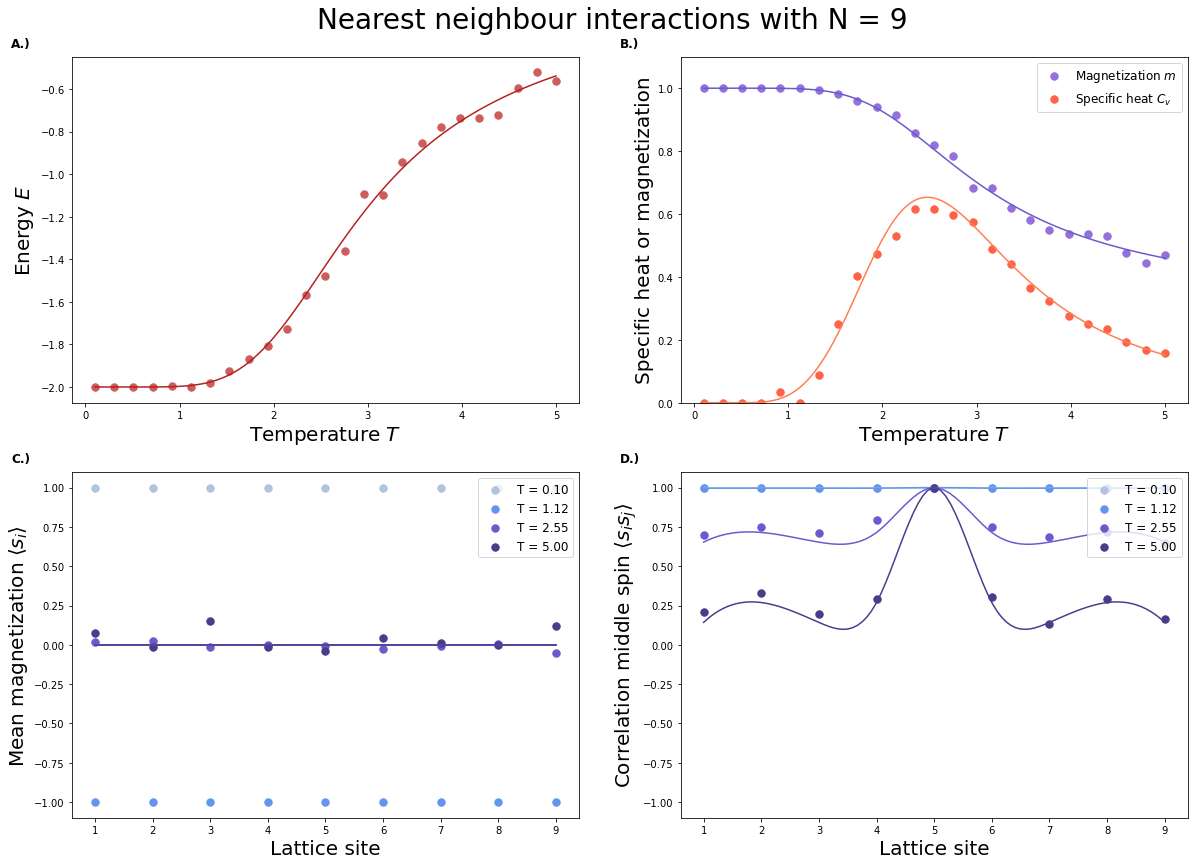

In [18]:
# RUN THE SIMULATION
#--------------------------------------------------------------------
#parameters
L       = 3                            #  linear dimension of the LxL lattice
T_min   = .1                           #  minimum temperature
T_max   = 5                            #  maximum temperature
nt      = 25                           #  amount of temperature steps
w       = 1                            #  strength of interactions 
h       = 0                            #  strength of self-interactions
eqSteps = 2**8                         #  number of MC sweeps for equilibration
mcSteps = 2**10                        #  number of MC sweeps for calculation
W_type  = 1                            #  0 for random weights, 1 for nb, 2 for fully connected

#random weights parametes
seed    = 777       
sigma   = 1

#simulate exact
E_ex,M_ex,Cv_ex,X_ex,Ci_ex,CiCj_ex,T,W_ex = ising_solve_exact(L, T_min, T_max, nt, w, h, W_type, seed, sigma)

#simulate MCMC
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

#plot

title = ('Nearest neighbour interactions with N = %.f' % L**2)
plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
#plt.savefig(("Figures/Classical Forward Ising Problem/nb_L=%.0f_w=%.2f_h=%2.f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,eqSteps,mcSteps)), bbox_inches='tight')

### In the limit MCMC converges to the exact calculation

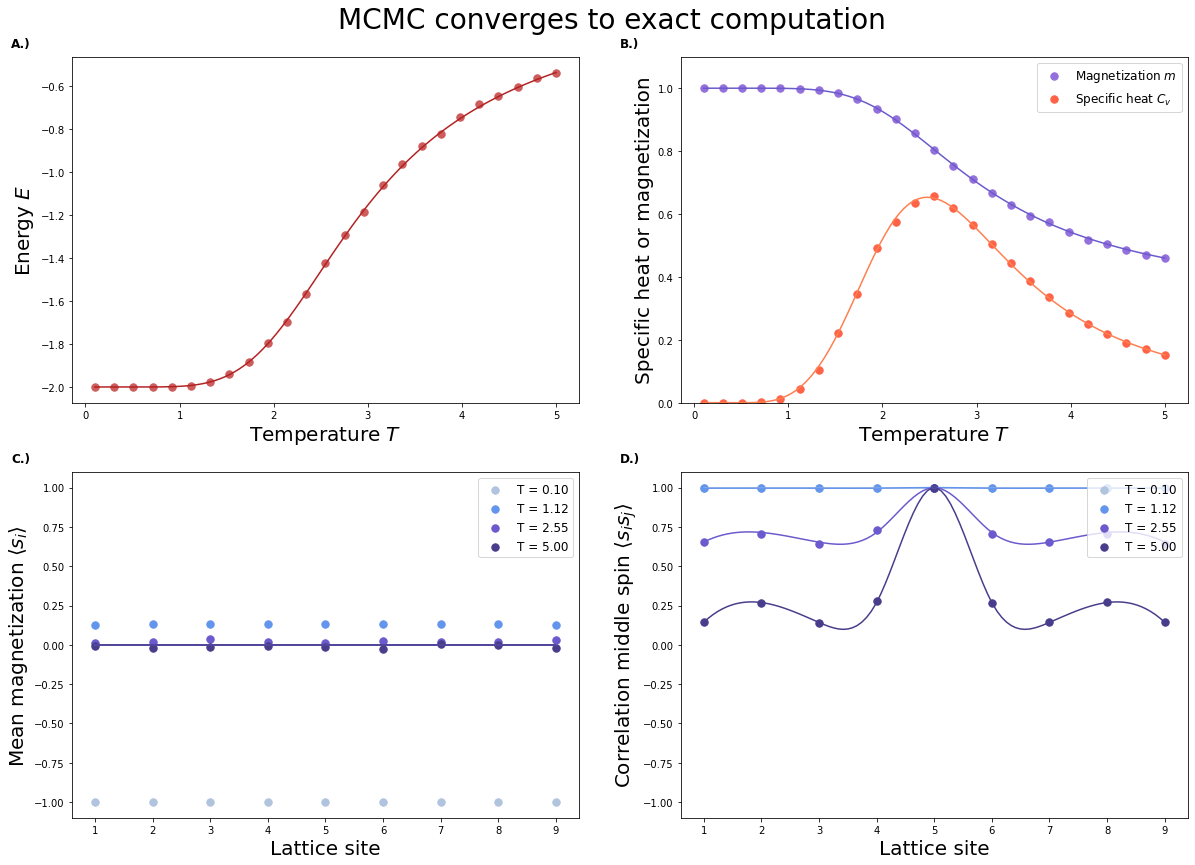

In [7]:
mcSteps = 2**14  #  number of MC sweeps for calculation

E_ex,M_ex,Cv_ex,X_ex,Ci_ex,CiCj_ex,T,W_ex = ising_solve_exact(L, T_min, T_max, nt, w, h, W_type, seed, sigma)
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

title = ('MCMC converges to exact computation')
plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
plt.savefig(("Figures/Classical Forward Ising Problem/nb_L=%.0f_w=%.2f_h=%2.f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,eqSteps,mcSteps)), bbox_inches='tight')

### MCMC can simulate larger lattices

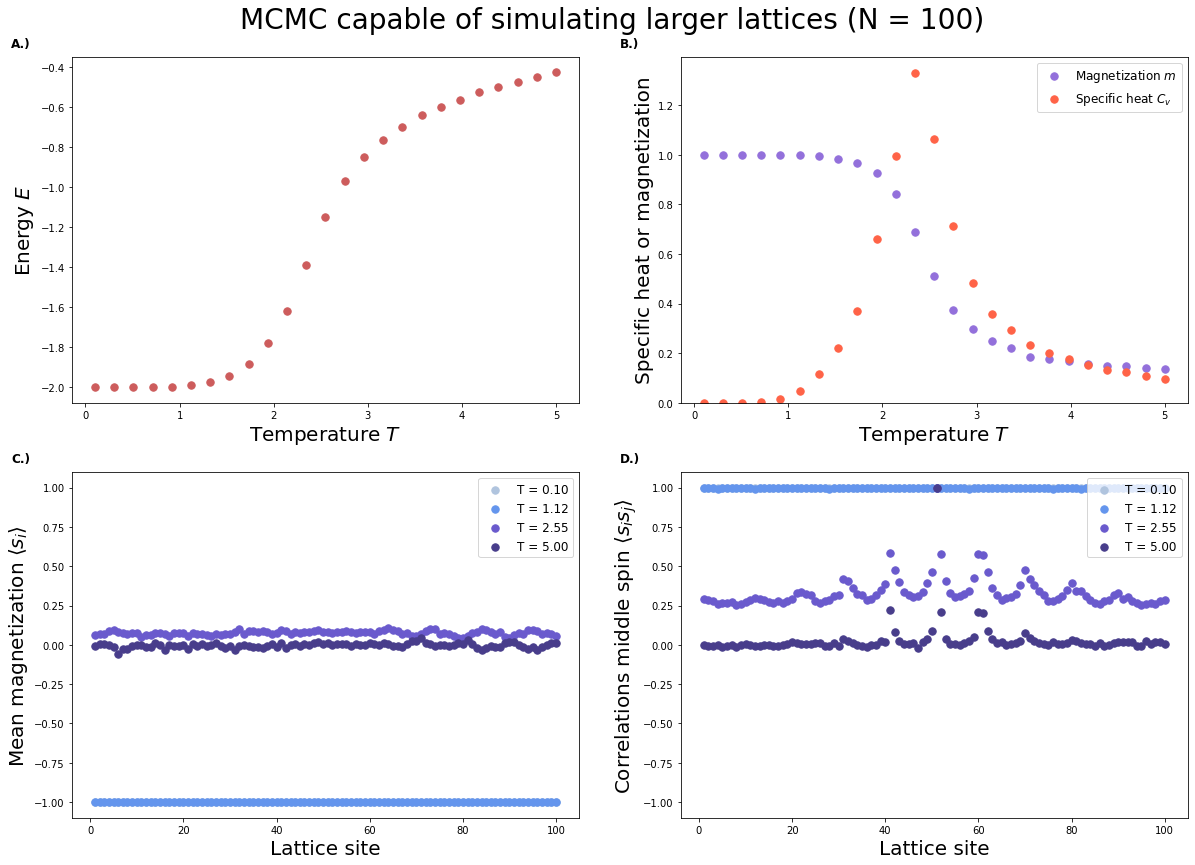

In [8]:
L = 10
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

#plot
title = ('MCMC capable of simulating larger lattices (N = %.0f)' % L**2)
plot_mc(E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
plt.savefig(("Figures/Classical Forward Ising Problem/nb_L=%.0f_w=%.2f_h=%2.f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,eqSteps,mcSteps)), bbox_inches='tight')

### C_v plots for different lattice sizes

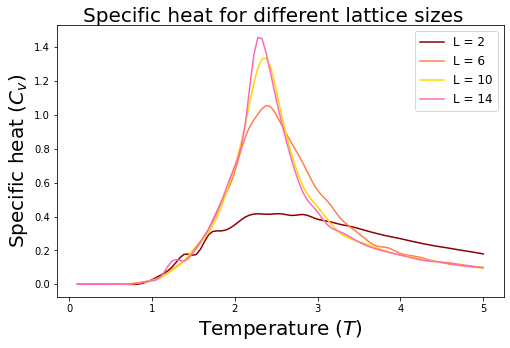

In [30]:
L_vals = np.arange(2,17,4)
nt = 35
mcSteps = 2**14

fig = plt.figure(figsize=(8, 5));                   
fig.suptitle('Specific heat for different lattice sizes', fontsize=20, y =0.93)
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel("Specific heat ($C_v$)", fontsize=20)
ax1.set_xlabel("Temperature ($T$)", fontsize=20)
L_labels = ["L = %.0f" % i for i in L_vals]
colours  = ["DarkRed","Coral","Gold", "HotPink"]
for i,L in enumerate(L_vals):
    N = L*L
    E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)
    
    if np.max(Cv_mc) > 2.5:
        max_index = np.argmax(Cv_mc)
        Cv_mc[max_index] = Cv_mc[max_index-1]
        
    f = interp1d(T, Cv_mc, kind='cubic')
    x_interp = np.linspace(T_min, T_max, num=100, endpoint=True)
    y_interp = f(x_interp)
    ax1.plot(x_interp, y_interp, color=colours[i])

ax1.legend(L_labels,loc='upper right', fontsize=12)
plt.savefig(("Figures/Classical Forward Ising Problem/specific heat lattice sizes nb.png"), bbox_inches='tight')

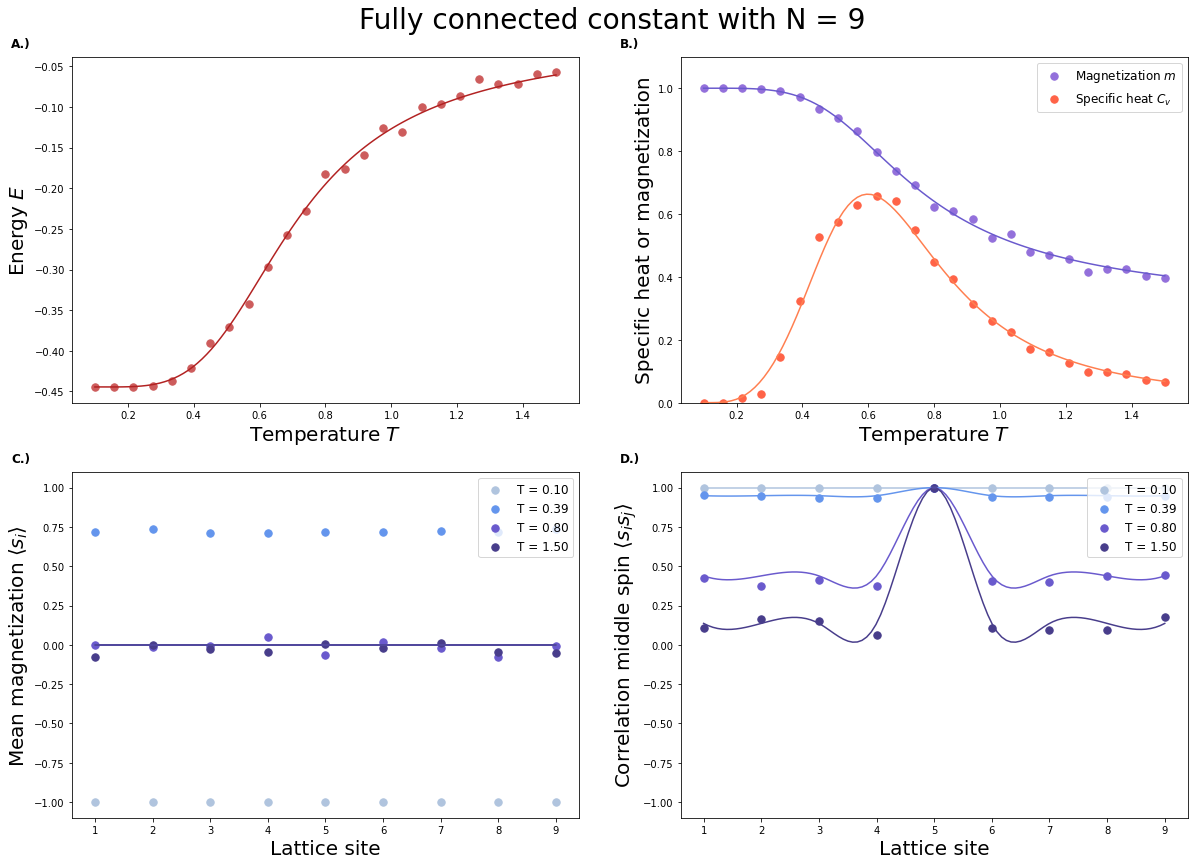

In [14]:
# RUN THE SIMULATION
#--------------------------------------------------------------------
#parameters
L       = 3                            #  linear dimension of the LxL lattice
T_min   = .1                           #  minimum temperature
T_max   = 1.5                          #  maximum temperature
nt      = 25                           #  amount of temperature steps
w       = 1                            #  strength of interactions 
h       = 0                            #  strength of self-interactions
eqSteps = 2**8                         #  number of MC sweeps for equilibration
mcSteps = 2**10                        #  number of MC sweeps for calculation
W_type  = 2                            #  0 for random weights, 1 for nb, 2 for fully connected

#random weights parametes
seed    = 777       
sigma   = 1

#simulate exact
E_ex,M_ex,Cv_ex,X_ex,Ci_ex,CiCj_ex,T,W_ex = ising_solve_exact(L, T_min, T_max, nt, w, h, W_type, seed, sigma)

#simulate MCMC
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

#plot
title = ('Fully connected constant with N = %.f' % L**2)
plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
plt.savefig(("Figures/Classical Forward Ising Problem/fc_constant_L=%.0f_w=%.2f_h=%2.f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,eqSteps,mcSteps)), bbox_inches='tight')

# Main results for fully connected ferromagnet

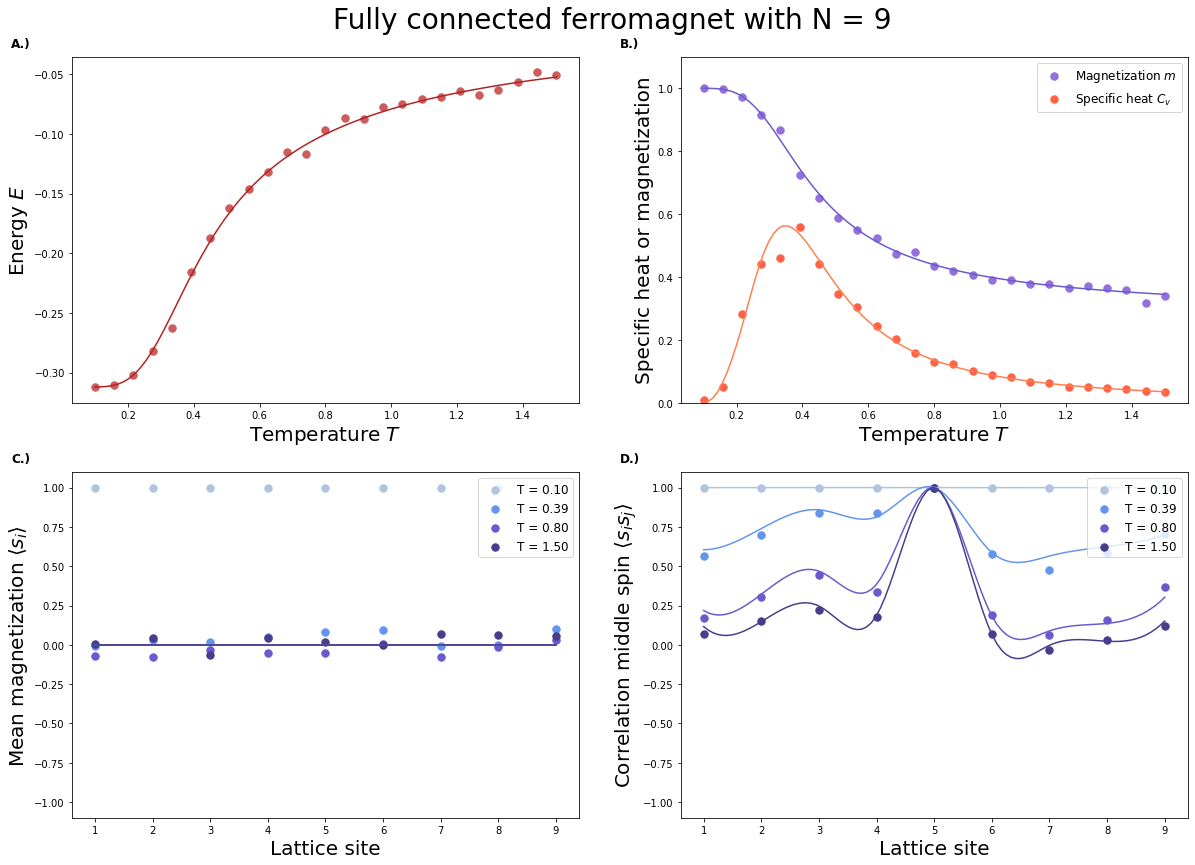

In [15]:
# RUN THE SIMULATION
#--------------------------------------------------------------------
#parameters
L       = 3                            #  linear dimension of the LxL lattice
T_min   = .1                           #  minimum temperature
T_max   = 1.5                          #  maximum temperature
nt      = 25                           #  amount of temperature steps
w       = 1                            #  strength of interactions 
h       = 0                            #  strength of self-interactions
eqSteps = 2**8                         #  number of MC sweeps for equilibration
mcSteps = 2**10                         #  number of MC sweeps for calculation
W_type  = 0                            #  0 for random weights, 1 for nb, 2 for fully connected

#random weights parametes
seed    = 777       
sigma   = .5

#simulate exact
E_ex,M_ex,Cv_ex,X_ex,Ci_ex,CiCj_ex,T,W_ex = ising_solve_exact(L, T_min, T_max, nt, w, h, W_type, seed, sigma)

#simulate MCMC
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

#plot
title = ('Fully connected ferromagnet with N = %.f' % L**2)
plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
plt.savefig(("Figures/Classical Forward Ising Problem/fc_ferro_L=%.0f_w=%.2f_h=%2.f_sigma=%.2f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,sigma,eqSteps,mcSteps)), bbox_inches='tight')

# Main results for fully connected frustrated

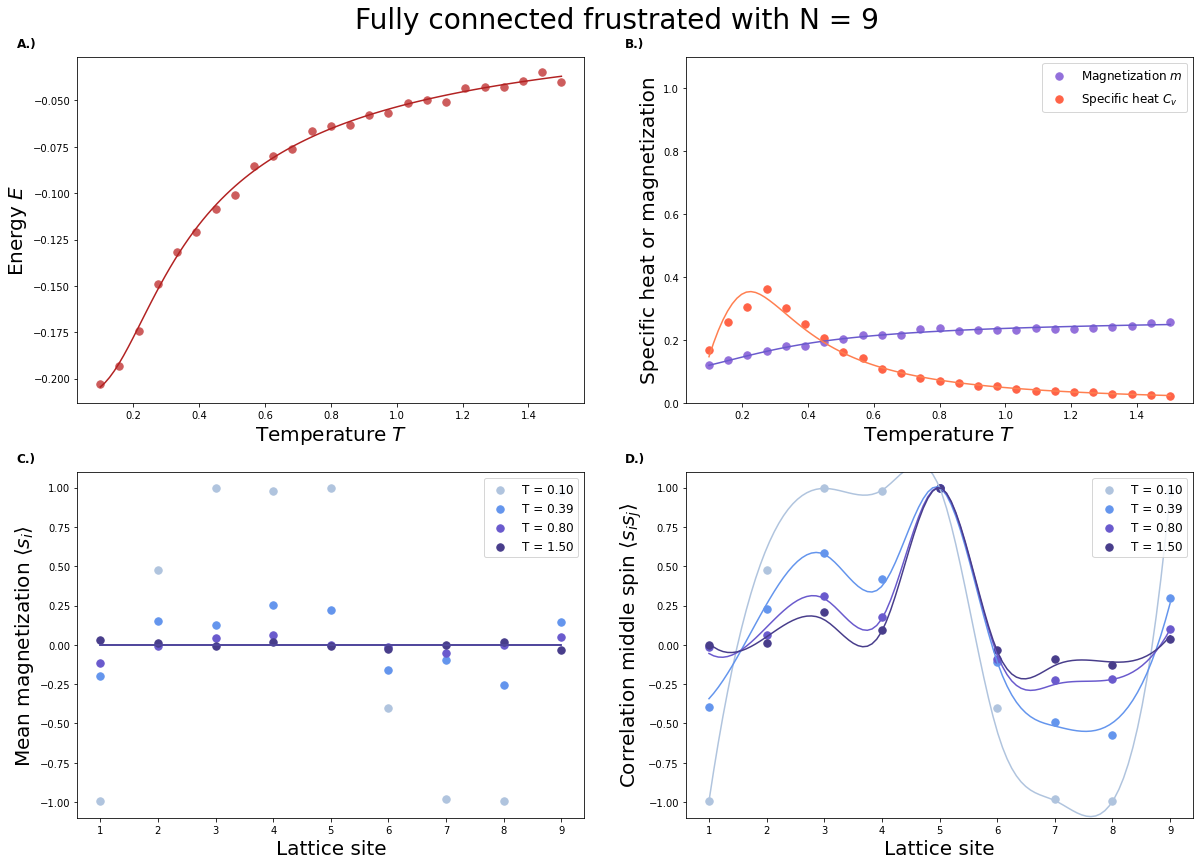

In [16]:
# RUN THE SIMULATION
#--------------------------------------------------------------------
#parameters
L       = 3                            #  linear dimension of the LxL lattice
T_min   = .1                           #  minimum temperature
T_max   = 1.5                          #  maximum temperature
nt      = 25                           #  amount of temperature steps
w       = 0                            #  strength of interactions 
h       = 0                            #  strength of self-interactions
eqSteps = 2**8                         #  number of MC sweeps for equilibration
mcSteps = 2**10                         #  number of MC sweeps for calculation
W_type  = 0                            #  0 for random weights, 1 for nb, 2 for fully connected

#random weights parametes
seed    = 777       
sigma   = .5

#simulate exact
E_ex,M_ex,Cv_ex,X_ex,Ci_ex,CiCj_ex,T,W_ex = ising_solve_exact(L, T_min, T_max, nt, w, h, W_type, seed, sigma)

#simulate MCMC
E_mc,M_mc,Cv_mc,X_mc,Ci_mc,CiCj_mc,T,W_mc = ising_solve_mc(L, T_min, T_max, nt, w, h, W_type, eqSteps, mcSteps, seed, sigma)

#plot
title = ('Fully connected frustrated with N = %.f' % L**2)
plot_exact(E_ex, M_ex, Cv_ex, Ci_ex, CiCj_ex, E_mc, M_mc, Cv_mc, Ci_mc, CiCj_mc, T, title)
plt.savefig(("Figures/Classical Forward Ising Problem/fc_frustrated_L=%.0f_w=%.2f_h=%2.f_sigma=%.2f_eqSteps=%.0f_mcSteps=%.0f.png"%(L,w,h,sigma,eqSteps,mcSteps)), bbox_inches='tight')